# Autoregressive Character-level Language Model

## 2. Multi Layer Perceptron MLP Model

### Reading & Building dataset

In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from striprtf.striprtf import rtf_to_text
%matplotlib inline

In [64]:
with open("names.rtf") as infile:
    content = infile.read()
    text = rtf_to_text(content)
    words = text.splitlines()
words[0:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [65]:
#building vocabulary of cahracters and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [66]:
# building dataset but with train, dev, test splits of 80%, 10%, 10%

def build_dataset(words):

    block_size = 3 #context length: how many characters to take to predict the next one
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

### Implementing the paramters for NN & training the model on training data

In [168]:
Xtr.shape, Ytr.shape #dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [204]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [205]:
sum(p.nelement() for p in parameters)

11897

### Implementing training loop using mini batches

In [206]:
for p in parameters:
    p.requires_grad=True

In [207]:
lre = torch.linspace(-3,0,10000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [224]:
for i in range(200000):


    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (32,))

    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    # implementing all this using F.cross_entropy
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean() 
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats (learning rate)
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)

# print(loss.item())

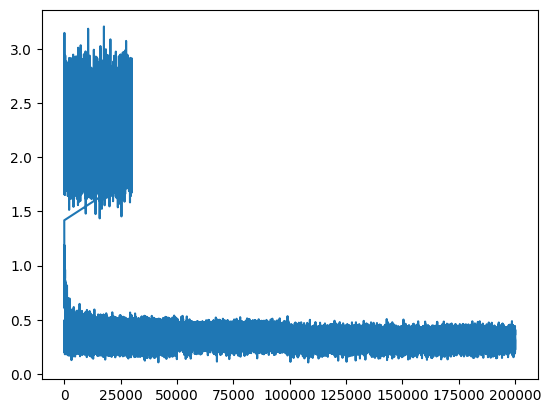

In [225]:
plt.plot(stepi, lossi)

In [226]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0921, grad_fn=<NllLossBackward0>)

In [227]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1497, grad_fn=<NllLossBackward0>)

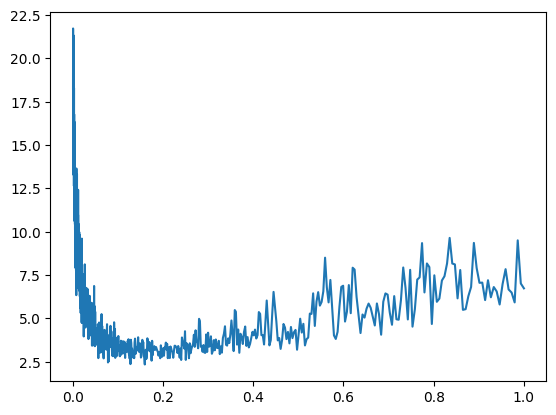

In [155]:
# plt.plot(lri, lossi) #plotting learning rate vs loss

### Visualising character embeddings

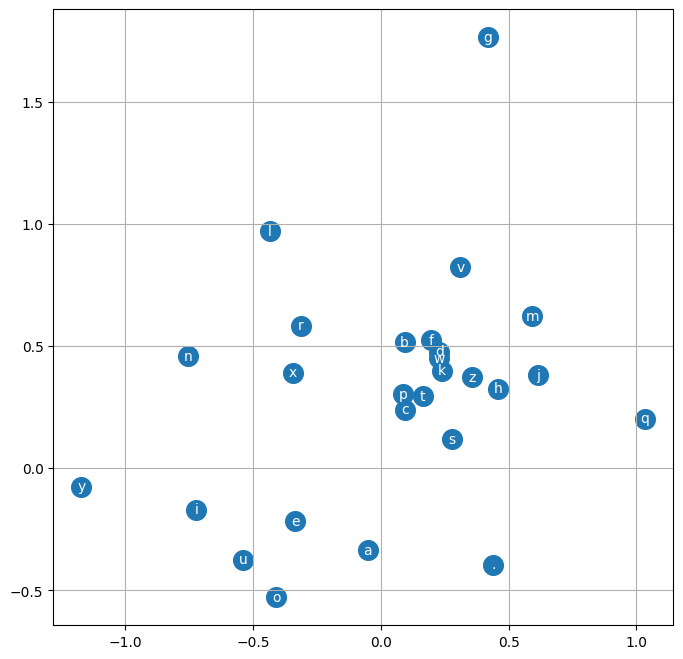

In [203]:
plt.figure(figsize=(8,8)) #visualising embeddings = 2, but then changed it up to 10
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### Sampling from the MLP model now

In [230]:
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amilli.
khy.
mir.
reity.
skanden.
jazhetladeliah.
jareei.
ner.
kirichaiiddy.
leigh.
ham.
jorn.
quint.
shous.
alian.
quinte.
madiarynn.
frae.
pinsleen.


In [231]:
# mlp better than bigram for sure but still room for improvement